# Trading View Sentiment Analysis

In [6]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import clone
import scipy.sparse as sparse
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# PreProcessing Data

In [7]:
df = pd.read_csv('/Users/rohitsuvarna/Downloads/Trading view project/idea_data.csv',usecols=['label','text','ticker'])
data_clean = df.loc[df['label'].isin(['Long','Short'])]
data_clean = data_clean[-pd.isnull(data_clean["text"])]
corpus = data_clean["text"].tolist()
#len(corpus)

## Features Extraction

In [8]:
vectorizer = CountVectorizer(
    stop_words='english',
    analyzer='word',
    min_df = 2,
    token_pattern='(?u)\\b[a-zA-Z]\\w+\\b' 
)
X_corpus_docterm = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names()
#features
CV = X_corpus_docterm.toarray()
df_sparse_vec = pd.DataFrame(CV)
data_clean1 = data_clean['label'].reset_index()
df_sparse_vec['label'] = data_clean1['label']
df_sparse_vec['label'] = df_sparse_vec['label'].map({'Long': 1, 'Short': 0})
#df_sparse_vec
ticker = set(data_clean['ticker'])
def checkTickerInDoc(doc, ticker):
    ticker_list = []
    doc = doc.split()
    count = 0
    for t in ticker:
        if t in doc and t not in ticker_list:
            #print(t)
            ticker_list.append(t)
            count += 1
    if count == 0:
        haveTicker = 0
        multiTicker = 0
    elif count == 1:
        haveTicker = 1
        multiTicker = 0
    else:
        haveTicker = 1
        multiTicker = 1
    return haveTicker, multiTicker
counts = np.zeros([len(corpus),2])
for count,text in enumerate(data_clean['text']):
    counts[count,:] = checkTickerInDoc(text,ticker)
#counts.shape
res = checkTickerInDoc("Trade active: Active in this trade. Considering it's performing weak despite a bullish morning, this further confirms my trend suspicions. I estimate this is about a 4 day trade give or take",ticker)
#res
count_cols = pd.DataFrame(counts)
count_cols.columns = ['HaveTicker','Multiticker']
df_sparse_vec['HaveTicker'] = count_cols['HaveTicker']
df_sparse_vec['Multiticker'] = count_cols['Multiticker']
df_sparse_vec['Output'] = df_sparse_vec['label']
df_sparse_vec.drop(df_sparse_vec['label'])
df_sparse_vec = df_sparse_vec.drop('label',1)
#df_sparse_vec

# Two Class Model

## Split Data

In [9]:
from sklearn.model_selection import train_test_split
X = df_sparse_vec.drop('Output',1).as_matrix()
y = df_sparse_vec['Output'].as_matrix()
#y
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
logit_clf = SGDClassifier(random_state=42, loss = 'log')
logit_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
y_pred_l = logit_clf.predict(X_test)
#y_pred.shape

### Accuracy

In [12]:
print(sum(y_pred_l == y_test)/len(y_pred_l))

0.792954086053


### Precision  and  Recall

In [13]:
cm = confusion_matrix(y_test, y_pred_l)
#cm
recall = recall_score(y_test, y_pred_l)
precision = precision_score(y_test, y_pred_l)
y_score = logit_clf.decision_function(X_test)
print(recall)
print(precision)

0.921560222889
0.801043219076


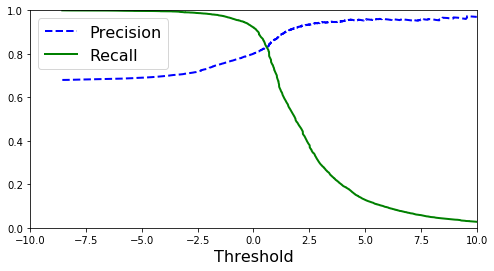

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-10, 10])
plt.show()

### ROC

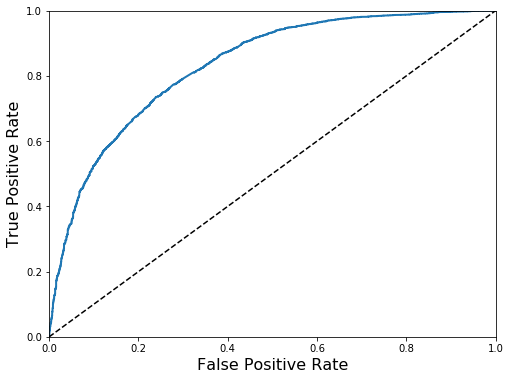

In [15]:
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_test,y_score)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## SVM

In [16]:
hinge_clf = SGDClassifier(random_state=42, loss='hinge') 
hinge_clf.fit(X_train, y_train)
y_pred_h= hinge_clf.predict(X_test)
y_score2= hinge_clf.decision_function(X_test)
#y_pred.shape_h

### Accurcy

In [17]:
print(sum(y_pred_h == y_test)/len(y_pred_h))

0.789777649437


### Precision  and  Recall

In [18]:
cm = confusion_matrix(y_test, y_pred_h)
#cm
recall = recall_score(y_test, y_pred_h)
precision = precision_score(y_test, y_pred_h)
print(recall)
print(precision)

0.929275610802
0.793848407177


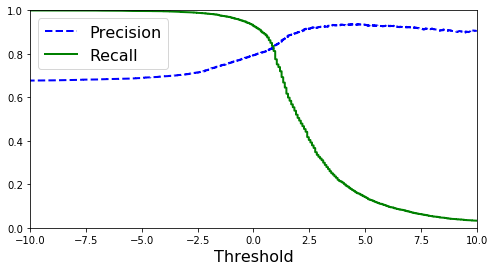

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_score2)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-10, 10])
plt.show()

### ROC

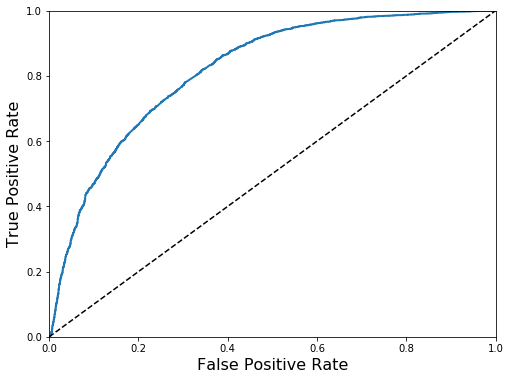

In [20]:
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_test,y_score2)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## Enriched Corpus

In [21]:
negative_word = pd.read_csv('/Users/rohitsuvarna/Downloads/LoughranMcDonald_Negative.csv', header = None)
positive_word = pd.read_csv('/Users/rohitsuvarna/Downloads/LoughranMcDonald_Positive.csv', header = None)
uncertainty_word = pd.read_csv('/Users/rohitsuvarna/Downloads/LoughranMcDonald_Uncertainty.csv', header = None)
negative_word_list=negative_word.iloc[:, 0].tolist()
positive_word_list=positive_word.iloc[:, 0].tolist()
uncertainty_word_list=uncertainty_word.iloc[:, 0].tolist()
corpus1=corpus+negative_word_list
corpus2=corpus1+positive_word_list#This is the extend corpus
vectorizer2 = CountVectorizer(
    stop_words='english',
    analyzer='word',
    min_df = 2,
    token_pattern='(?u)\\b[a-zA-Z]\\w+\\b' 
)
X_corpus_docterm2 = vectorizer2.fit_transform(corpus2)
CV2 = X_corpus_docterm2.toarray()
df_sparse_vec2 = pd.DataFrame(CV2)
#Here we only need to consider the Long/short ideas and not pos/neg words as our feature vectors
df_sparse_vec2 = df_sparse_vec2[:34628] 
#df_sparse_vec2
p1 = data_clean['label'].map({'Long': 1, 'Short': 0})
p1 = p1.reset_index()
p1 = p1.drop('index',1)
#p1
t1 = df_sparse_vec['HaveTicker']
t1 = t1.reset_index()
t1 = t1.drop('index',1)
#t1
s1 = df_sparse_vec['Multiticker']
s1 = s1.reset_index()
s1 = s1.drop('index',1)
#s1
df_sparse_vec2['HaveTicker'] = t1
df_sparse_vec2['Multiticker'] = s1
df_sparse_vec2['output'] = p1
#df_sparse_vec2

# Split Data 

In [22]:
X1 = df_sparse_vec2.drop('output',1).as_matrix()
y1= df_sparse_vec2['output'].as_matrix()
X_train1, X_test1, y_train1, y_test1 = train_test_split( X1, y1, test_size=0.2, random_state=42)

## Logistic Regression

In [23]:
logit_clf1 = SGDClassifier(random_state=42, loss = 'log')
logit_clf1.fit(X_train1,y_train1)
y_pred1 = logit_clf1.predict(X_test1)
cm1 = confusion_matrix(y_test1, y_pred1)
y_score1 = logit_clf1.decision_function(X_test1)
#cm1


### Accuracy

In [24]:
print(sum(y_pred1 == y_test1)/len(y_pred1))

0.794686687843


### Precision and Recall

In [25]:
recall1 = recall_score(y_test1, y_pred1)
precision1 = precision_score(y_test1, y_pred1)
print(recall1)
print(precision1)

0.922203171882
0.802499067512


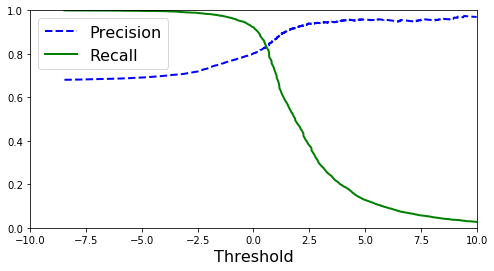

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test1, y_score1)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-10, 10])
plt.show()

### ROC

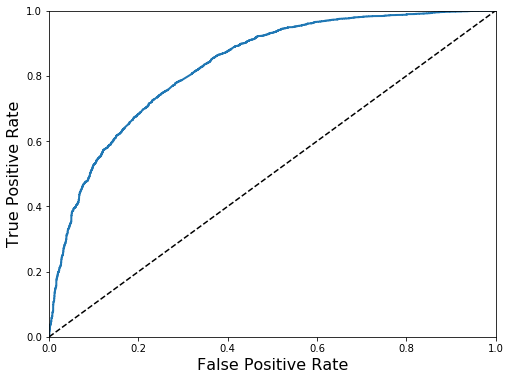

In [27]:
fpr1,tpr1, thresholds1 = roc_curve(y_test1,y_score1)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1)
plt.show()

## SVM

In [28]:
hinge_clf1 = SGDClassifier(random_state=42, loss='hinge') 
hinge_clf1.fit(X_train1, y_train1)
y_pred_h1= hinge_clf1.predict(X_test1)
y_score3 = hinge_clf1.decision_function(X_test1)
#y_pred_h1.shape
cm1 = confusion_matrix(y_test1, y_pred_h1)
#cm1


### Accuracy

In [29]:
print(sum(y_pred_h1 == y_test1)/len(y_pred_h1))

0.790932717297


### Precision and Recall

In [30]:
recall = recall_score(y_test1, y_pred_h1)
precision = precision_score(y_test1, y_pred_h1)
print(recall)
print(precision)

0.92413201886
0.797632260451


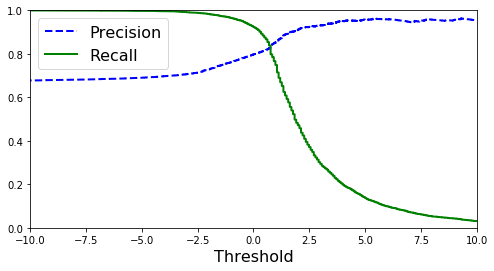

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test1, y_score3)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-10, 10])
plt.show()

### ROC

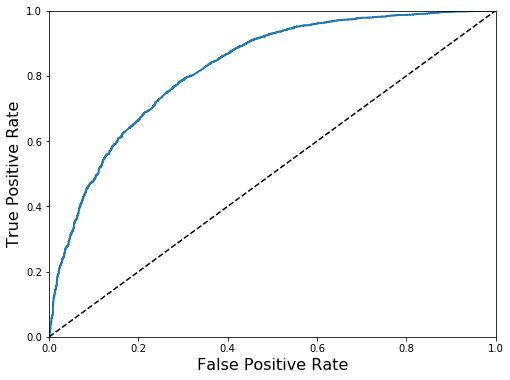

In [32]:
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_test1,y_score3)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

# Three Class Model

In [33]:
df = pd.read_csv('/Users/rohitsuvarna/Downloads/Trading view project/idea_data.csv',usecols=['label','text','ticker'])
df = df[-pd.isnull(df["text"])]
df['label'] = df['label'].replace(np.nan, 'Neutral')
#df = df[-pd.isnull(df["label"])]
df = df.reset_index()
df = df.drop('index',1)
df

,label,ticker,text
0,Neutral,A,Could be working on an IHS here
1,Neutral,A,Notes on chart
2,Long,A,Trade closed manually: looks like market comes...
3,Long,A,Long on positive earnings news and various upg...
4,Long,A,breakout and retest. bull flag . looks for LT
5,Short,A,Its going to be beautiful NOT INVESTMENT ADVICE
6,Neutral,A,"This consolidation, if combined with large vol..."
7,Short,A,Trade active: Active in this trade. Considerin...
8,Neutral,A,Update. Could be a nice handle here
9,Neutral,A,Look at the chart. Speaks for itself.


In [34]:
corpus3 = df["text"].tolist()
corpus3 = corpus3 + negative_word_list + positive_word_list + uncertainty_word_list

In [35]:
vectorizer3 = CountVectorizer(
    stop_words='english',
    analyzer='word',
    min_df = 2,
    token_pattern='(?u)\\b[a-zA-Z]\\w+\\b' 
)
ticker = set(data_clean['ticker'])
X_corpus_docterm3 = vectorizer3.fit_transform(corpus3)
features3 = vectorizer3.get_feature_names()
CV3 = X_corpus_docterm3.toarray()
df_sparse_vec3 = pd.DataFrame(CV3)
df_sparse_vec3 = df_sparse_vec3[:49911]
def checkTickerInDoc(doc, ticker):
    ticker_list = []
    doc = doc.split()
    count = 0
    for t in ticker:
        if t in doc and t not in ticker_list:
            #print(t)
            ticker_list.append(t)
            count += 1
    if count == 0:
        haveTicker = 0
        multiTicker = 0
    elif count == 1:
        haveTicker = 1
        multiTicker = 0
    else:
        haveTicker = 1
        multiTicker = 1
    return haveTicker, multiTicker
counts3 = np.zeros([len(corpus3),2])
for count,text in enumerate(df['text']):
    counts3[count,:] = checkTickerInDoc(text,ticker)
count_cols3 = pd.DataFrame(counts3)
count_cols3.columns = ['HaveTicker','Multiticker']
df_sparse_vec3['HaveTicker'] = count_cols3['HaveTicker']
df_sparse_vec3['Multiticker'] = count_cols3['Multiticker']
df_sparse_vec3['Output'] = df['label'].map({'Long': 2, 'Short': 0, 'Neutral':1,'Education':1})
df_sparse_vec3



,0,1,2,3,4,5,6,7,8,9,...,14595,14596,14597,14598,14599,14600,14601,HaveTicker,Multiticker,Output
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,2
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1


In [36]:
#df_sparse_vec3.isnull().sum()

In [37]:
#df['label'][4145]

In [38]:
#df_sparse_vec3['Output'] = df['label'].map({'Long': 1, 'Short': -1, 'Neutral':0,'Education':0 })
#a = df_sparse_vec3['Output']
#a = a.as_matrix()
#np.argwhere(np.isnan(a))

In [39]:
X3 = df_sparse_vec3.drop('Output',1).as_matrix()
y3= df_sparse_vec3['Output'].as_matrix()
X_train3, X_test3, y_train3, y_test3 = train_test_split( X3, y3, test_size=0.2, random_state=42)

In [40]:
logit_clf3 = SGDClassifier(random_state=42, loss = 'log')
logit_clf3.fit(X_train3,y_train3)
y_pred3 = logit_clf3.predict(X_test3)
cm3 = confusion_matrix(y_test3, y_pred3)
y_score3 = logit_clf3.decision_function(X_test3)
cm3

array([[1076,  349,  901],
       [ 333, 1098, 1611],
       [ 229,  497, 3889]])

 Accuracy

In [41]:
print(sum(y_pred3 == y_test3)/len(y_pred3))

0.607332465191


In [99]:
#a = df['label'].map({'Long': 1, 'Short': -1, 'Neutral':0})
#a = a.as_matrix()
#np.argwhere(np.isnan(a))
#a[4146]

0.0

In [47]:
recall3 = recall_score(y_test3, y_pred3, average = 'micro')
precision3 = precision_score(y_test3, y_pred3, average = 'micro')

In [48]:
recall3

0.55541012290815972

In [49]:
precision3

0.60975826341914974